In [33]:
import IPython, IPython.display
import numpy, PIL
import cStringIO
import scipy.ndimage
import scipy.misc

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

def fimg_ar_as_PIL(img_ar):
    return PIL.Image.fromarray(numpy.uint8(img_ar))
def fimg_PIL_as_ar(img_pil):
    return numpy.array(img_pil)
def fimg_ar_disp_IPython(img_ar):
    io = cStringIO.StringIO()
    fimg_ar_as_PIL(img_ar).save(io, 'bmp')
    IPython.display.display(IPython.display.Image(data=io.getvalue()))
def fimg_ar_disp(img_ar):
    fimg_ar_disp_IPython(img_ar)
import matplotlib.image
def fimg_load_ar(img_path):
    return matplotlib.image.imread(img_path)
def fimg_ar_size(img_ar):
    return (len(img_ar[0]) if img_ar is not None and len(img_ar) else 0.0, len(img_ar) if img_ar is not None else 0.0)
def fimg_ar_racoon():
    return scipy.misc.face()
def fimg_ar_resize(img_ar, scl):
    return scipy.ndimage.zoom(img_ar, (scl[0],scl[1],1))
def fimg_filled(img_sz, color_val = 0):
    img = np.zeros([img_sz[0],img_sz[1],3],dtype=np.uint8)
    if color_val != 0:
        img.fill(color_val)
    return img

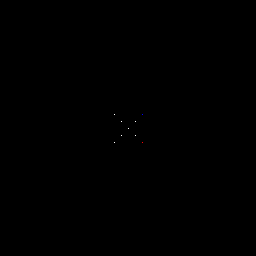

In [443]:
import numpy as np
def fpinhole_matrix(focal):
    return [[focal, 0, 0, 0],[0, focal, 0, 0],[0, 0, 1, 0], [0,0,0,1]]
def fpinhole_lookat_matrix(src, tgt, up):
    fwd = np.subtract(tgt, src)
    left = np.cross(up, fwd)
    up = np.cross(fwd, left)
    base = [left, up, fwd]
    return [list(base[i]/np.linalg.norm(base[i])) + [src[i]] for i in range(3)] + [[0.0,0.0,0.0,1.0]]
def fviewport_func(img_sz, scl):
    off = [x*0.5 for x in img_sz] 
    return lambda pt_2d: [int(0.5 + (pt_2d[i]*scl+off[i])) for i in range(2)]
def fpinhole_project_pt(matrix, pt):
    homog = np.dot(matrix, list(pt) + [1.0])
    return [homog[0]/homog[2], homog[1]/homog[2]]
def fpinhole_project_img(pin_mat, view_func, pts, img, pt_colors=[255,255,255]):
    img_sz = fimg_ar_size(img)
    for i_pt, pt in enumerate(pts):
        pt_2d = fpinhole_project_pt(pin_mat, pt)
        pt_2d = [-pt_2d[0], -pt_2d[1]]
        pt_img = view_func(pt_2d)
        #print pt_2d, view_func(pt_2d)
        if all([pt_img[i] >= 0 and pt_img[i] < img_sz[i] for i in range(2)]):
            img[pt_img[1]][pt_img[0]] = pt_colors[i_pt if i_pt < len(pt_colors) else 0]
def ftest_pinhole():
    #print fpinhole_project_pt(fpinhole_matrix(0.1), [1,2,3])
    pin_img = fimg_filled([256,256])
    pin_mat = fpinhole_matrix(7.e-2)
    view_func = fviewport_func(fimg_ar_size(coon), 200.0)
    pts = [ [0, 0, 1], 
           [-1,-1,1], [-1,1,1] , [1,1,1], [1,-1,1], 
           [-1,-1,2], [-1,1,2] , [1,1,2], [1,-1,2]
          ]
    pt_cols = [[255,255,255], [255,0,0], [0,0,255]]
    fpinhole_project_img(pin_mat, view_func, pts, pin_img, pt_cols)
    fimg_ar_disp(pin_img)
ftest_pinhole()
#print fpinhole_lookat_matrix([1,0,0], [0,0,5], [0,1,0])

In [444]:
import re

def _fread_obj_vertices_str(obj_str):
    regex = r"^v\s(-?(0|[1-9]\d*)(\.\d+)?)\s(-?(0|[1-9]\d*)(\.\d+)?)\s(-?(0|[1-9]\d*)(\.\d+)?)"
    matches = re.finditer(regex, obj_str, re.MULTILINE)
    verts = []
    for i, match in enumerate(matches):
        verts.append([float(match.groups()[i]) for i in [0,3,6]])
    return verts
def fread_obj_vertices_str(obj_str):
    regex = r"^v\s(.+)\s(.+)\s(.+)"
    matches = re.finditer(regex, obj_str, re.MULTILINE)
    verts = []
    for i, match in enumerate(matches):
        verts.append([float(match.groups()[i]) for i in [0,1,2]])
    return verts
def fread_obj_vertices_file(file):
    verts = []
    with open(file) as fi:
        for line in fi:
            verts.extend(fread_obj_vertices_str(line))
    return verts
def ftest_obj():
    print fread_obj_vertices_file('./data/suzanne.obj')
#ftest_obj()

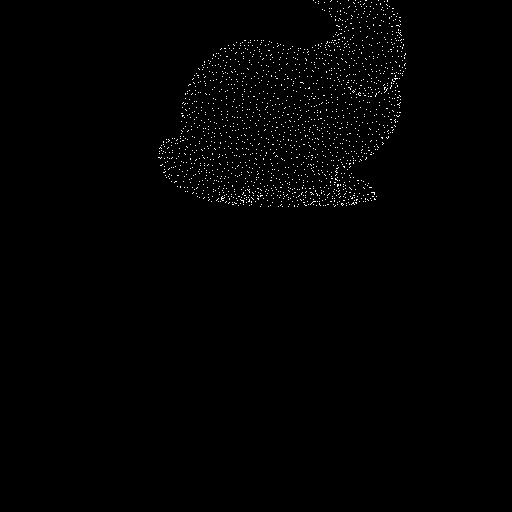

In [456]:
def frender_suzanne():
    pin_img = fimg_filled([512,512])
    pin_mat = fpinhole_matrix(25.e-3)
    pin_view = np.linalg.inv( fpinhole_lookat_matrix([0.0, 0.0, -0.3], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0]) )
    view_func = fviewport_func(fimg_ar_size(pin_img), 20000.0)
    pts = np.array(fread_obj_vertices_file('./data/bunny.obj'))
    #pts = [x + [0.0, 0.0,1.2] for x in pts]
    #print pts
    #print pin_mat, pin_view
    pin_mat = np.dot(pin_mat, pin_view)
    #print pin_mat
    fpinhole_project_img(pin_mat, view_func, pts, pin_img)
    fimg_ar_disp(pin_img)
frender_suzanne()

[[0.01, 0, 0, 0], [0, 0.01, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
[[ 1.   0.   0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   1.   0.5]
 [ 0.   0.   0.   1. ]]
[[0.01, 0, 0, 0], [0, 0.01, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
[0.0, 0.0] [256, 256]
[-0.00125, 0.0] [244, 256]
[-0.00125, 0.0] [244, 256]


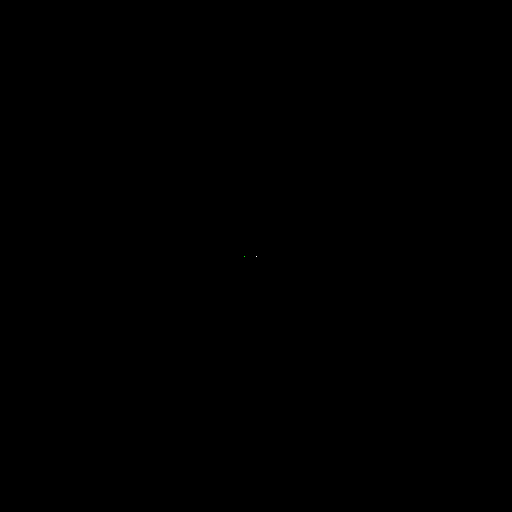

In [419]:
def frender_strip():
    pin_img = fimg_filled([512,512])
    pin_mat = fpinhole_matrix(10.e-3)
    pin_view = np.linalg.inv( fpinhole_lookat_matrix([0.0, 0.0, -0.5], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0]) )
    view_func = fviewport_func(fimg_ar_size(pin_img), 10000.0)
    pts = [[0,0,1.0+0], [-0.1, 0, 1.0+-0.2], [-0.1, 0, 1.0+-0.2], [0.1, 0, 1.0+0.2], [-0.1, 0, 1.0+0.2]][0:3]
    pt_cols = [[255,255,255], [255,0,0], [0,255,0]]
    print pin_mat
    print pin_view
    #pin_mat = np.dot(pin_mat, pin_view)
    print pin_mat
    fpinhole_project_img(pin_mat, view_func, pts, pin_img, pt_cols)
    fimg_ar_disp(pin_img)
frender_strip()